In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:85% !important;}</style>"))

%load_ext autoreload
%autoreload 2
%matplotlib inline

import logging

from sklearn.datasets import make_classification

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import lightgbm as lgb
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler, StandardScaler

from probatus.sample_similarity import SHAPImportanceResemblance

In [2]:
from helpers import gen_samples, setup_logging, shift_features, psi

setup_logging()

# Generate some data

Generate 20000 rows with 15 features, of which 5 are exponential, 5 anre uniform and 5 are normally distributed


In [3]:
data_raw = gen_samples(n_samples = 20000)


2021-01-07 23:10:20 - INFO - gen_samples: Generating 5 exponential features with 20000 rows
2021-01-07 23:10:20 - INFO - gen_samples: Generating 5 uniform features with 20000 rows
2021-01-07 23:10:20 - INFO - gen_samples: Generating 5 normal features with 20000 rows


In [4]:
make_copy = lambda x: x.copy()

data = (
    data_raw
    .pipe(make_copy)
    .pipe(shift_features, cols_to_shift = data_raw.columns, min_max_scaler_range=(1,100))
)

features = [col for col in data_raw.columns if col.startswith("col_")]

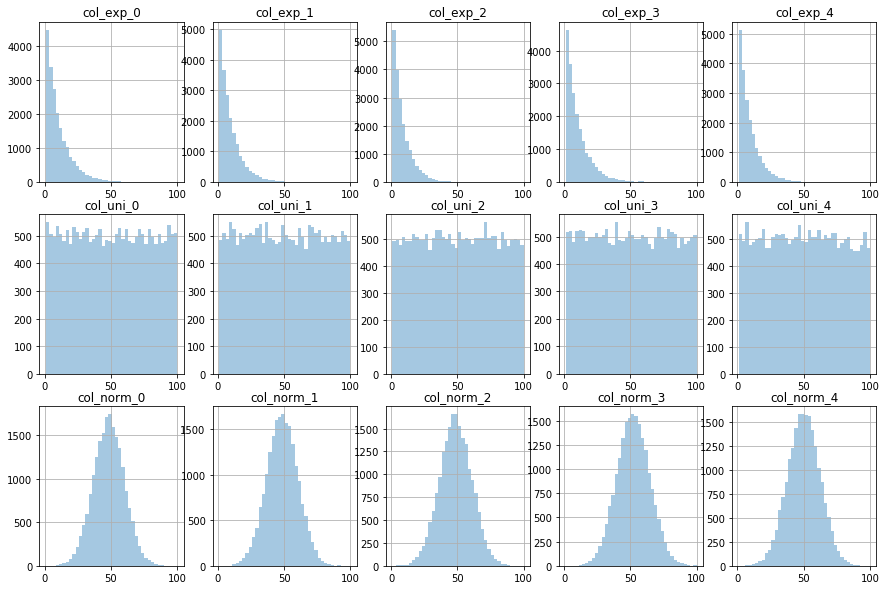

In [5]:
fig, ax = plt.subplots(3,5, figsize=(15,10))

for ix,col in enumerate([col for col in features]):
    ix_horiz = ix%5
    ix_vert = int(ix/5)                  
    data[col].hist(bins=40,alpha=0.4, ax = ax[ix_vert][ix_horiz])
    ax[ix_vert][ix_horiz].set_title(col)

### Let's impose a shift in all the features ending with _3 and _4

In [6]:
cols_to_shift = [
    col for col in data.columns
    if col.endswith("_3") or col.endswith("_4")
]
print(cols_to_shift)

data_shift = (
    data_raw
    .pipe(make_copy)
    .pipe(shift_features, cols_to_shift = data.columns, min_max_scaler_range=(1,100))
    .pipe(shift_features, cols_to_shift = cols_to_shift, min_max_scaler_range=(21,120))
)

['col_exp_3', 'col_exp_4', 'col_uni_3', 'col_uni_4', 'col_norm_3', 'col_norm_4']


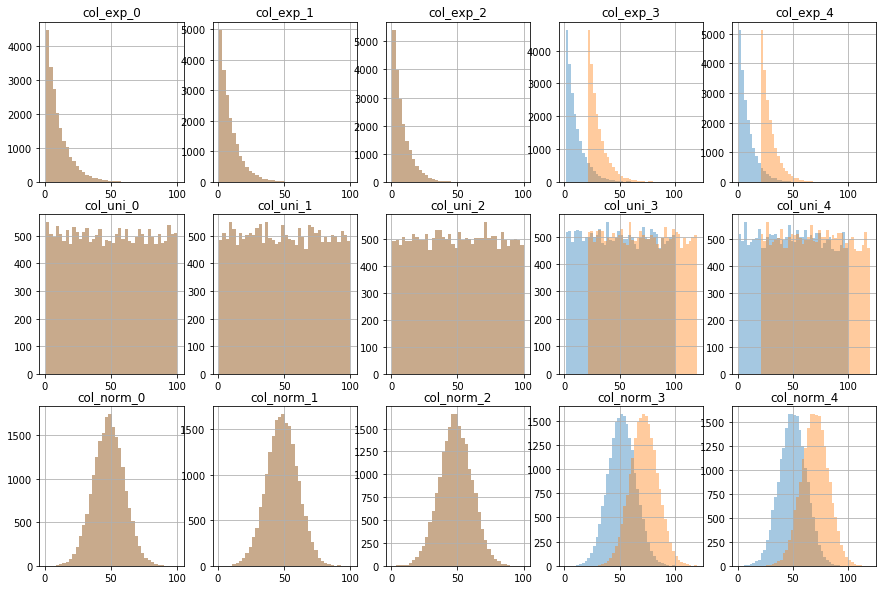

In [7]:
fig, ax = plt.subplots(3,5, figsize=(15,10))

for ix,col in enumerate([col for col in data.columns if "time" not in col]):
    ix_horiz = ix%5
    ix_vert = int(ix/5)                  
    data[col].hist(bins=40,alpha=0.4, ax = ax[ix_vert][ix_horiz])
    data_shift[col].hist(bins=40,alpha=0.4, ax = ax[ix_vert][ix_horiz])
    ax[ix_vert][ix_horiz].set_title(col)

# Time to add the targets

As we are in a simulation setting, let's make the 

`targen` (**Tar**get **Gen**eration) is a package available on pip<br>, and it helps to define a simulated target based on a relationship between features decided by the Data Scientist.<br>
Very handy to test some methodologies in a "controlled" environment <br>
`pip install targen`

In [8]:
from targen.data import target

In [9]:
interaction_terms = "".join([
    "2.5*col_exp_2*col_exp_3",
    "-0.2*col_uni_2*col_uni_3",
    "+0.7*col_norm_2*col_norm_3",
    
    "+0.8*col_norm_2*col_uni_3", #
    "-1.3*col_uni_2/col_exp_3", # the shift shoul reduce here the effect  
])
interaction_terms

'2.5*col_exp_2*col_exp_3-0.2*col_uni_2*col_uni_3+0.7*col_norm_2*col_norm_3+0.8*col_norm_2*col_uni_3-1.3*col_uni_2/col_exp_3'

In [10]:
expressions = {
    'linear': '-0.5*col_exp_0 + 0.3*col_uni_0 -0.2*col_norm_0',
    'non_linear': '0.7*col_exp_2**1.5 - 0.2*sin(col_norm_2)- 0.9*log(col_uni_2)',
    'interaction': interaction_terms,
        'conditional': {
        'col_uni_4>0':(
            0, #True
            0 #False
        )},
    'uniform_noise': {
        'weight':3.7
    },
    'gaussian_noise': {
        'weight':5.4,
        'mu_gaus': -1.5
    }
}

#### Generate the targets (and the useful metadata) based on the desired relationships

In [11]:
tmp = target.get_target_and_contributions(data, expressions=expressions, imbalance = 0.1)
# tmp_shift = target.get_target_and_contributions(data_shift, expressions=expressions, imbalance = 0.1)

In [12]:
tmp.head()

,score_linear,score_non_linear,score_interaction,score_conditional,score_uniform_noise,score_gaussian_noise,score_total,y
0,0.059026,1.192217,-3.939840,0,-2.424256,1.001949,-4.110904,1
1,-0.072317,-0.029775,-25.392283,0,-1.544610,-2.605979,-29.644964,0
2,-0.016270,0.249817,-43.820480,0,-0.756921,-7.512822,-51.856676,0
3,0.028396,0.531527,-16.106333,0,-0.787825,-5.357053,-21.691288,0
4,0.061409,0.021940,-8.731565,0,0.950455,4.529534,-3.168226,1


### What are the expected performances of each subset?

In [13]:
from sklearn.metrics import roc_auc_score

print(f"Linear component: {roc_auc_score(tmp['y'],tmp['score_linear'])}")
print(f"Non Linear component: {roc_auc_score(tmp['y'],tmp['score_non_linear'])}")
print(f"Interaction component: {roc_auc_score(tmp['y'],tmp['score_interaction'])}")
print(f"Conditional component: {roc_auc_score(tmp['y'],tmp['score_conditional'])}")
print(f"Total component: {roc_auc_score(tmp['y'],tmp['score_linear'] + tmp['score_non_linear'] + tmp['score_interaction'] + tmp['score_conditional'])}")
# print(f"Total component: {roc_auc_score(tmp['y'],tmp['score_linear'] + tmp['score_non_linear'] + tmp['score_interaction'])}")

Linear component: 0.5091679444444444
Non Linear component: 0.7799272777777777
Interaction component: 0.8755018611111112
Conditional component: 0.5
Total component: 0.877639638888889


In [14]:
y = tmp['y']

# Time to build a model
Let's keep it simple: take a RandomForest

In [15]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data[features],y, test_size=0.25, random_state=42)

X_test_ix = X_test.index

X_shift_test = data_shift[features].iloc[X_test_ix]
y_shift_test = y_test

In [17]:
y_train.value_counts()

0    13499
1     1501
Name: y, dtype: int64

In [18]:
rf = RandomForestClassifier(
    n_estimators=10,
    max_leaf_nodes=6, 
    random_state=42, 
    bootstrap=False # No bootstrap here for simplicitt, will be clear at the end of the notebook
).fit(X_train, y_train)

### What does the performance look like?

In [19]:
print(f"Train distribution {roc_auc_score(y_train,rf.predict_proba(X_train)[:,1])}")
print(f"Test distribution {roc_auc_score(y_test,rf.predict_proba(X_test)[:,1])}")
print(f"Shifted Test distribution {roc_auc_score(y_test,rf.predict_proba(X_shift_test)[:,1])}")

Train distribution 0.8359562647298522
Test distribution 0.8162973358403098
Shifted Test distribution 0.810647956655368


**Note the decrease in performance on the shifted distributions!!**

Let's see what the model learned...

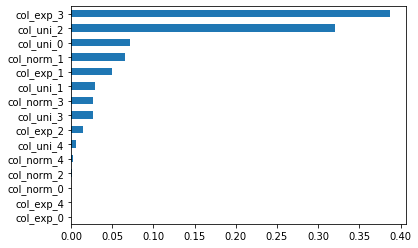

In [20]:
feat_imp = pd.Series(rf.feature_importances_, index = features).sort_values(ascending=True)
feat_imp.plot(kind='barh')

#### Recall the relationships feature targets

In [21]:
expressions

{'linear': '-0.5*col_exp_0 + 0.3*col_uni_0 -0.2*col_norm_0',
 'non_linear': '0.7*col_exp_2**1.5 - 0.2*sin(col_norm_2)- 0.9*log(col_uni_2)',
 'interaction': '2.5*col_exp_2*col_exp_3-0.2*col_uni_2*col_uni_3+0.7*col_norm_2*col_norm_3+0.8*col_norm_2*col_uni_3-1.3*col_uni_2/col_exp_3',
 'conditional': {'col_uni_4>0': (0, 0)},
 'uniform_noise': {'weight': 3.7},
 'gaussian_noise': {'weight': 5.4, 'mu_gaus': -1.5}}

# Small divergence - decompose a tree-ensemble model

Every ensemble tree model can be considered as a "convolution" of two functions,

- a function $f_{map}(X,y)$ that transforms the features $X$ from the "feature-space" to $X_{tree}$ in the "tree-space".<br>
This features takes care of all the interactions of the returns buckets in the "tree-space"

- a function  $f_{pred}(X,y)$ that maps the $X_{tree}$ to probabilities by a GLM-type of model

<img src="IMG-0155.PNG"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px:"
       width="1000" />
    
### For a random forest model, 

- $f_{pred}(X,y)$  is the average of the targets in the leaves
- $f_{pred}(X,y)$ and $f_{map}(X,y)$ are "indipendent at training time

### For xgboost/lightgbm 
- $f_{pred}(X,y)$ is a weighter linear sum of the leaf values, where the weight is the learning rate, and the leaf values are computed using the gradients & hessians of the loss function
- $f_{pred}(X,y)$ and $f_{map}(X,y)$ are **not** "indipendent at training time


# Look at an example to clarify

<img src="IMG-0156.PNG"
     alt="Markdown Monster icon"
     style="float: left; margin-right: 10px;"
     width="1200"/>

<!-- [!image] -->

### Back to some code

Some handy functions

In [22]:
def calculate_pred_per_tree(rf_model, X,y):
        
    leaves,mapping, columns = compute_leaves(rf_model, X,y)
        
    preds = pd.concat([
        leaves[col].map(mapping[col]) for col in columns
    ], 
        axis =1)
    
    return preds

def compute_leaves(rf_model, X,y=None):
    leaves = rf_model.apply(X)
        
    columns = [f'tree_{i}' for i in range(leaves.shape[1])]
    
    leaves = pd.DataFrame(leaves,columns = columns, index = X.index)
    
    mapping = dict()
    
    if y is not None:
        leaves['y'] = y
        for col in columns:
            mapping[col] = leaves.groupby(col)['y'].mean().to_dict()
            
    return leaves,mapping, columns
      

### Transform from the 15-dimensional feature space in the 10-dimensional "tree-space"

In [23]:
leaves, *dummy = compute_leaves(rf,X_train,y_train)
leaves

,tree_0,tree_1,tree_2,tree_3,tree_4,tree_5,tree_6,tree_7,tree_8,tree_9,y
5514,8,9,1,3,9,1,4,5,3,4,0
1266,8,9,1,3,9,1,1,5,3,6,0
5864,8,9,1,3,9,1,4,5,6,4,0
15865,8,9,5,5,10,7,10,5,2,4,1
12892,8,9,1,3,9,1,5,5,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...
11284,8,9,1,3,9,1,4,5,3,4,0
11964,8,9,1,3,9,1,7,5,10,4,0
5390,8,9,1,3,9,1,4,5,3,4,0
860,8,9,1,3,9,1,4,5,6,4,0


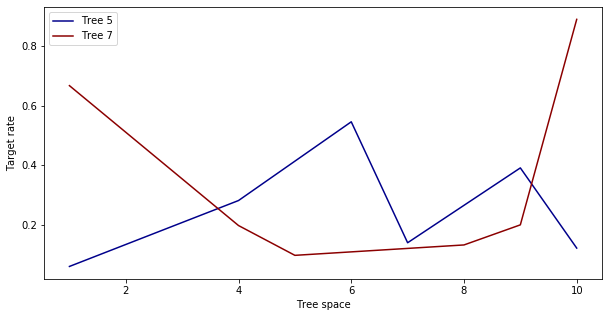

In [24]:
fig, ax = plt.subplots(figsize=(10,5))
leaves.groupby("tree_5")['y'].mean().plot(color='darkblue', ax=ax, label = "Tree 5")
leaves.groupby("tree_7")['y'].mean().plot(color='darkred', ax=ax,  label = "Tree 7")
ax.set_xlabel("Tree space")
ax.legend()
dummy = ax.set_ylabel("Target rate")

# What happens with the probatus - resemblance modelling?

In [25]:
rf_rm = RandomForestClassifier(n_estimators=10,max_leaf_nodes=6, random_state=42, bootstrap=False)

rm_std = SHAPImportanceResemblance(rf_rm)
feature_importance_std, train_auc_std, test_auc_std = rm_std.fit_compute(X_train, X_shift_test, column_names=features, return_scores=True)
test_auc_std


0.999

In [26]:
feature_importance_std.head(6)

,mean_abs_shap_value,mean_shap_value
col_exp_3,0.139967,0.010126
col_exp_4,0.118597,-0.003421
col_norm_3,0.054593,0.004237
col_norm_4,0.035596,-0.004277
col_uni_4,0.017568,-0.003209
col_uni_3,0.012576,-0.004741


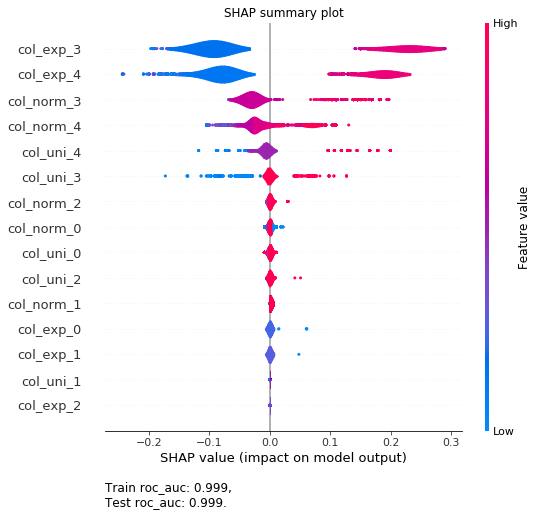

In [27]:
rm_std.plot(plot_type="violin")

### Comments

- recall that the resemblance modelling in probatus (and also true for the majority of shift metrics) never considers the relationship between the feature and the targets.
- in this experiment, all features ending with `_3` and `_4` are shifted, and the resemblance modelling has no issue finding the splits!

However, this is telling us that there is a separation between the samples, but it does not care about the learnings of the model, as it will train its own best model that will be optimized to catch the shifts!

### Let's use the trained model, and decompose it as described above

This Snippet of code:
- will create a new RandomForest model, that will inherit the mapping from $X$ to $X_{tree}$ from the fitted model, and will not re-run the fits. <br>
- It will also calculate the leave outputs (which in this case are the average of the targets in the leaves), and thanks to the `bootstrap=False` it assures that the results are the same when tested on the same features (but might differ on different samples) (see test case below).

In [28]:
class MyRF(RandomForestClassifier):
    
    def __init__(self,fitted_model):
        
        self.model = fitted_model
        self.estimators_ = fitted_model.estimators_
        self.criterion = fitted_model.criterion
    
    def fit(self, X,y):
        
        self._fit_columns = X.columns
        
        self.leaves, self.mapping, self.columns = compute_leaves(self.model,X,y)

        return self
        
    def predict_proba(self,X):
        
        assert (X.columns == self._fit_columns).all(), f"Shape of X is wrong: Expected {len(self.columns)}, got { len(X.columns)}"
        
        leaves, *dummy = compute_leaves(self.model,X,y=None)
        
        preds = pd.concat([
            leaves[col].map(self.mapping[col]) for col in self.columns
        ], axis =1)
        
        preds_1 = preds.mean(axis=1).values
        
        out = np.array([[p0, p1] for p0,p1 in zip(1-preds_1, preds_1)])
        
        return out

In [29]:
myrf = MyRF(rf).fit(X_train,y_train)


Assure that `myrf` and `rf` return the same predictions

In [30]:
np.testing.assert_almost_equal(myrf.predict_proba(X_train)[:,1] , rf.predict_proba(X_train)[:,1])

### Back to probatus and resemblance modelling

In [31]:
rm_manual = SHAPImportanceResemblance(myrf)
feature_importance, train_auc, test_auc = rm_manual.fit_compute(X_train, X_shift_test, column_names=features, return_scores=True)
test_auc

0.945

In [32]:
feature_importance.head(5)

,mean_abs_shap_value,mean_shap_value
col_exp_3,0.036741,0.014746
col_uni_2,0.018049,0.000150
col_uni_4,0.001567,-0.000398
col_uni_0,0.001119,-0.000038
col_norm_1,0.000698,0.000016


compared to the standard resemblance modelling

In [33]:
feature_importance_std.head(5)

,mean_abs_shap_value,mean_shap_value
col_exp_3,0.139967,0.010126
col_exp_4,0.118597,-0.003421
col_norm_3,0.054593,0.004237
col_norm_4,0.035596,-0.004277
col_uni_4,0.017568,-0.003209


# Graphically speaking it looks as follows

Tweaked Random Forest + Resemblance modelling

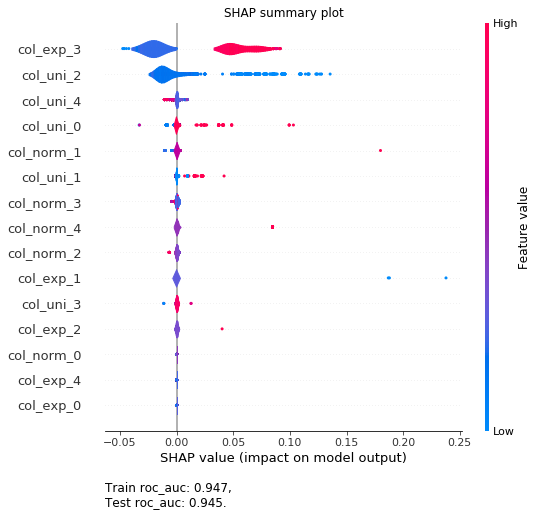

In [34]:
rm_manual.plot(plot_type="violin")

Standard Random Forest + Resemblance modelling

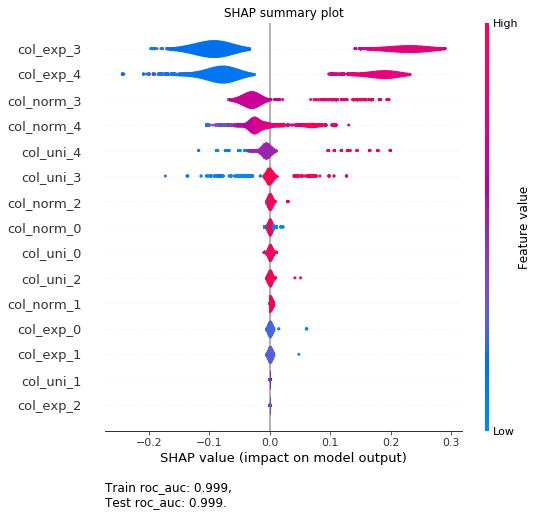

In [35]:
rm_std.plot(plot_type="violin")


# Experimental part: Can I extract some more info?

For example, if I use the recalculated predictions and compare where the shifts are?

In [36]:
preds_train = calculate_pred_per_tree(rf, X_train, y_train)
preds_test = calculate_pred_per_tree(rf, X_test, y_test)
preds_shift_test = calculate_pred_per_tree(rf, X_shift_test, y_test)

### Plot the difference per decision tree

Where the differences are relevant, probably some interactions between population shifts are present.

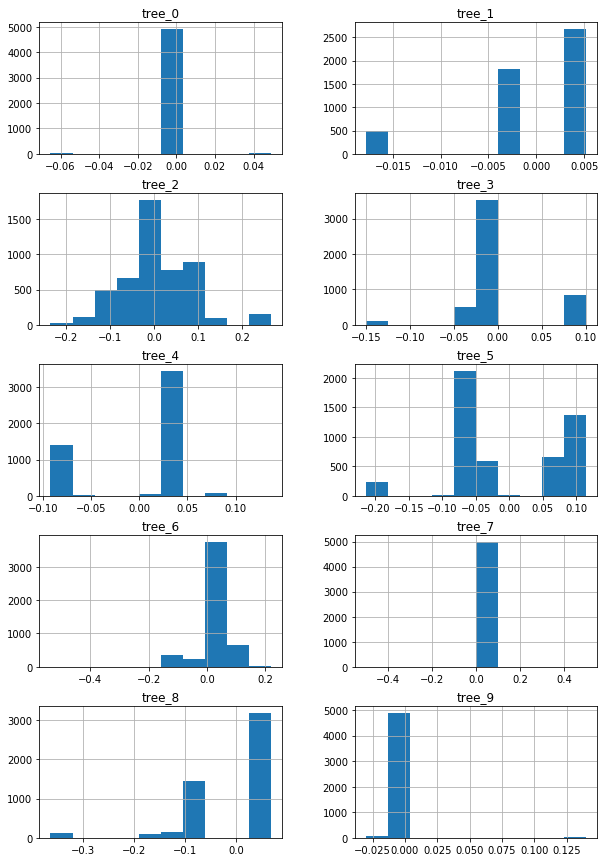

In [37]:
fig, ax = plt.subplots(5,2, figsize=(10,15))
dummy = (preds_shift_test - preds_test).hist(ax=ax)

In [38]:
print(interaction_terms)

2.5*col_exp_2*col_exp_3-0.2*col_uni_2*col_uni_3+0.7*col_norm_2*col_norm_3+0.8*col_norm_2*col_uni_3-1.3*col_uni_2/col_exp_3


In [39]:
from sklearn.tree import plot_tree

['col_exp_1', 'col_uni_0', 'col_uni_1', 'col_uni_2', 'col_uni_3']


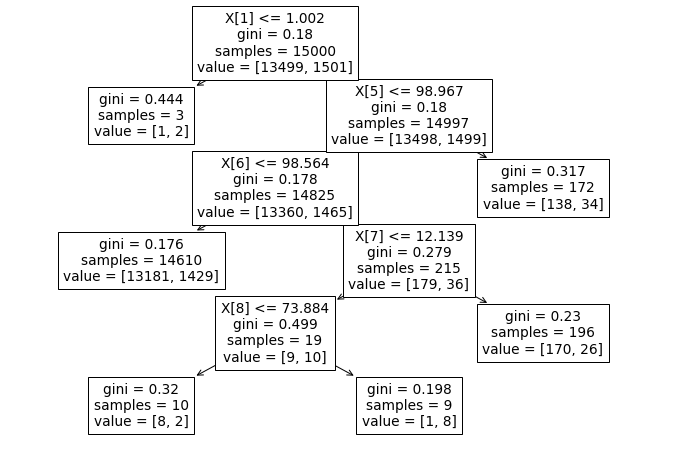

In [42]:
tree_ix = 7
inspect_Tree = rf.estimators_[tree_ix]

used_columns = [features[ix] for ix in np.unique(inspect_Tree.tree_.feature) if ix>=0]

print(used_columns)

fig, ax = plt.subplots(figsize=(12,8))
dummy = plot_tree(inspect_Tree)

['col_exp_3', 'col_uni_2', 'col_uni_4', 'col_norm_1']


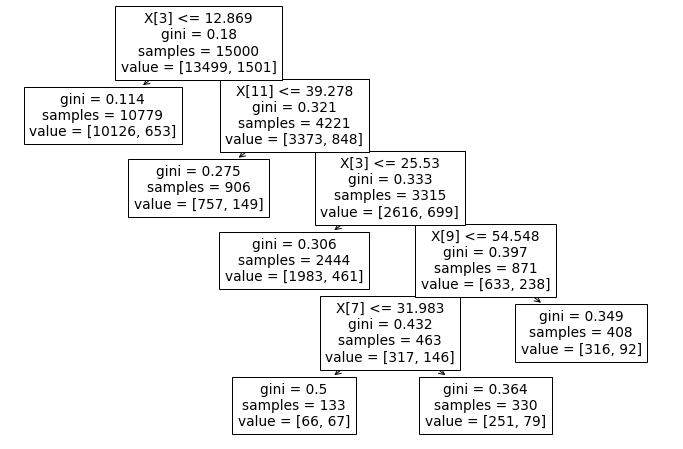

In [43]:
tree_ix = 2
inspect_Tree = rf.estimators_[tree_ix]

used_columns = [features[ix] for ix in np.unique(inspect_Tree.tree_.feature) if ix>=0]

print(used_columns)

fig, ax = plt.subplots(figsize=(12,8))
dummy = plot_tree(inspect_Tree)
